In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
import kagglehub

# Download dataset
dataset_path = kagglehub.dataset_download("iamtapendu/chest-x-ray-lungs-segmentation")

# Define file paths
IMG_PATH = os.path.join(dataset_path, "Chest-X-Ray", "Chest-X-Ray", "image")
MSK_PATH = os.path.join(dataset_path, "Chest-X-Ray", "Chest-X-Ray", "mask")

# Image dimensions
IMG_SIZE = (256, 256)

# Load images and masks
def load_data(img_path, mask_path, img_size):
    images = []
    masks = []

    img_files = sorted(os.listdir(img_path))
    mask_files = sorted(os.listdir(mask_path))

    for img_file, mask_file in zip(img_files, mask_files):
        img = load_img(os.path.join(img_path, img_file), target_size=img_size)
        img = img_to_array(img) / 255.0

        mask = load_img(os.path.join(mask_path, mask_file), target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        mask = (mask > 0.5).astype(np.uint8)  # Binarize mask

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(IMG_PATH, MSK_PATH, IMG_SIZE)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

100%|██████████| 3.59G/3.59G [02:52<00:00, 22.3MB/s]

Extracting files...


In [2]:
# Load DenseNet121 model from TensorFlow
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Define DenseNet121 Model

def build_DenseNet121(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Upsampling to match 256x256 output
    x = UpSampling2D((16, 16), interpolation="bilinear")(x)  # 16x16 -> 256x256
    x = UpSampling2D((2, 2), interpolation="bilinear")(x)   # 256x256 -> final output

    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)  # Ensure 1-channel output

    return Model(inputs, outputs)

# Compile model
model = build_DenseNet121((IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=2)])

# Train model
model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_split=0.1)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 280s 4s/step - accuracy: 0.7856 - loss: 0.4521 - mean_io_u: 0.3656 - val_accuracy: 0.8707 - val_loss: 0.3201 - val_mean_io_u: 0.3728
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9413 - loss: 0.1422 - mean_io_u: 0.3649 - val_accuracy: 0.9229 - val_loss: 0.1981 - val_mean_io_u: 0.3728
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9528 - loss: 0.1132 - mean_io_u: 0.3716 - val_accuracy: 0.9390 - val_loss: 0.1547 - val_mean_io_u: 0.3729
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9577 - loss: 0.1011 - mean_io_u: 0.3817 - val_accuracy: 0.9428 - val_loss: 0.1410 - val_mean_io_u: 0.3737
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9595 - loss: 0.0955 - mean_io_u: 0.3929 - val_accuracy: 0.9438 - val_loss: 0.1360 - val_mean_io_u: 0.3761
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9632 - loss: 0.0882 - me

In [3]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

dice_scores = [dice_score(Y_test[i], y_pred[i]) for i in range(len(Y_test))]
iou_scores = [np.sum(Y_test[i] * y_pred[i]) / (np.sum(Y_test[i]) + np.sum(y_pred[i]) - np.sum(Y_test[i] * y_pred[i]) + 1e-7) for i in range(len(Y_test))]

print(f"Mean Dice Score: {np.mean(dice_scores):.4f}")
print(f"Mean IoU: {np.mean(iou_scores):.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step
Mean Dice Score: 0.8912
Mean IoU: 0.8069


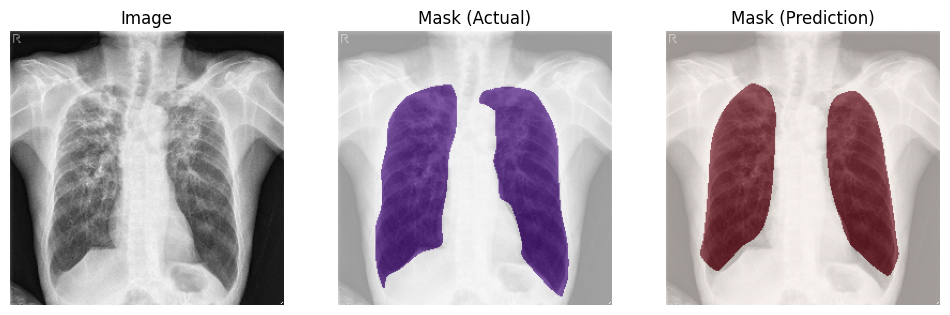

In [4]:
# Visualization of results
def visualize_results(index):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(X_test[index], cmap='gray')
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(X_test[index], cmap='gray')
    axes[1].imshow(Y_test[index].squeeze(), cmap='Purples', alpha=0.6)
    axes[1].set_title("Mask (Actual)")
    axes[1].axis("off")

    axes[2].imshow(X_test[index], cmap='gray')
    axes[2].imshow(y_pred[index].squeeze(), cmap='Reds', alpha=0.6)
    axes[2].set_title("Mask (Prediction)")
    axes[2].axis("off")

    plt.show()

# Show visualization for a sample image
visualize_results(0)

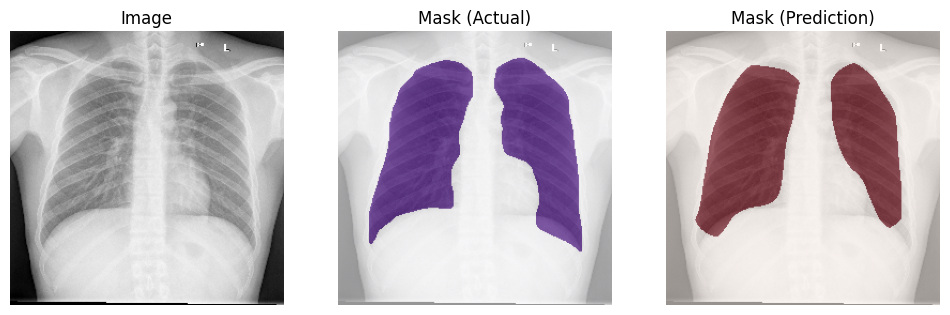

In [5]:
visualize_results(1)

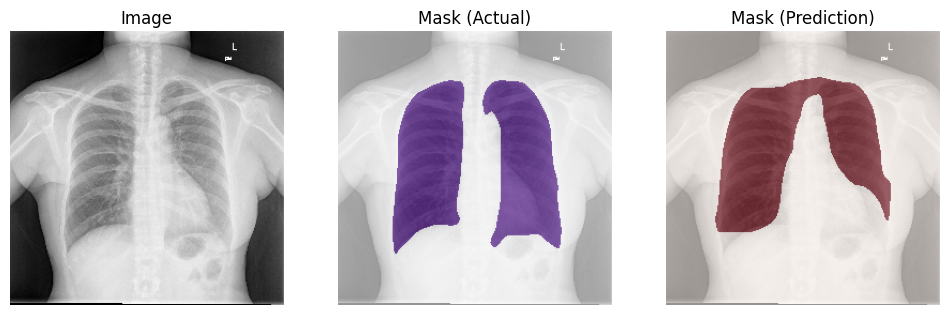

In [9]:
visualize_results(2)